#Step 1a
Downloading the MNIST dataset

In [ ]:
# !pip install mnist

In [ ]:
# fashion_mnist = keras.datasets.fashion_mnist
# (X_train TEXTBOOK CHAPTER 10) (WATCH BEGINNING OF LAST WEEKS LECTURE)
# import tensorflow as tf
# fashion_mnist = tf.keras.datasets.mnist
# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
!pip install dataget

In [ ]:
import dataget
train_images, train_labels, test_images, test_labels = dataget.image.fashion_mnist().get()

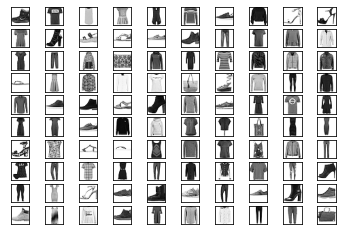

In [ ]:
# import mnist    #cCONVERT TO FASHION MNIST FFS
import numpy as np
# mnist.temporary_dir = lambda: '/tmp'
# train_images = mnist.train_images().tolist()
# train_labels = mnist.train_labels().tolist()
# test_images = mnist.test_images().tolist()
# test_labels = mnist.test_labels().tolist()

# np.shape(train_images) == [60000, 28, 28]
# np.shape(train_labels) == [60000]
train_images = train_images.tolist()
train_labels = train_labels.tolist()
# print(type(train_labels))
# print(train_labels)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(10, 10)

for i in range(10):
    for j in range(10):
        # Plot each image in black and white and hide the axes.
        ax[i][j].imshow(train_images[10 * i + j], cmap='Greys')
        ax[i][j].xaxis.set_visible(False)
        ax[i][j].yaxis.set_visible(False)

plt.show()

In [ ]:
Tensor = list
def is_1d(tensor: Tensor) -> bool:
    """
    If tensor[0] is a list, it's a higher-order tensor.
    Otherwise, tensor is 1-dimensonal (that is, a vector).
    """
    # print('inside is 1d: is it a 1d?:')
    # print(type(tensor))
    # # # print(isinstance(tensor[0], list))
    # # try:
    # #     print(isinstance(tensor[0], list))
    # #     print(type(tensor[0]))
    # # except IndexError:
    # print("index error",tensor)
    return not isinstance(tensor[0], list)
    
def tensor_sum(tensor: Tensor) -> float:
    """Sums up all the values in the tensor"""
    if is_1d(tensor):
        return sum(tensor)  # just a list of floats, use Python sum
    else:
        return sum(tensor_sum(tensor_i)      # Call tensor_sum on each row
                   for tensor_i in tensor)   # and sum up those results.


#Step 2
Used ReLu and Sigmoid layers to classify

In [ ]:
from typing import List
def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]
    return 
    
def one_hot_encode(i: int, num_labels: int = 10) -> List[float]:
    # return [1.0 if j == i else 0.0 for j in range(num_labels)]
    if i==0:
        return [1,0]
    return [0,1]

In [ ]:
# def is_1d(tensor: Tensor) -> bool:
#     """
#     If tensor[0] is a list, it's a higher-order tensor.
#     Otherwise, tensor is 1-dimensonal (that is, a vector).
#     """
#     print('inside is 1d: is it a 1d?:')
#     print(type(tensor))
#     # # print(isinstance(tensor[0], list))
#     # try:
#     #     print(isinstance(tensor[0], list))
#     #     print(type(tensor[0]))
#     # except IndexError:
#     print("index error",tensor)
#     return not isinstance(tensor[0], list)
    
# def tensor_sum(tensor: Tensor) -> float:
#     """Sums up all the values in the tensor"""
#     if is_1d(tensor):
#         return sum(tensor)  # just a list of floats, use Python sum
#     else:
#         return sum(tensor_sum(tensor_i)      # Call tensor_sum on each row
#                    for tensor_i in tensor)   # and sum up those results.

In [ ]:
from typing import Iterable, Tuple
class Layer:
    """
    Our neural networks will be composed of Layers, each of which
    knows how to do some computation on its inputs in the "forward"
    direction and propagate gradients in the "backward" direction.
    """
    def forward(self, input):
        """
        Note the lack of types. We're not going to be prescriptive
        about what kinds of inputs layers can take and what kinds
        of outputs they can return.
        """
        raise NotImplementedError

    def backward(self, gradient):
        """
        Similarly, we're not going to be prescriptive about what the
        gradient looks like. It's up to you the user to make sure
        that you're doing things sensibly.
        """
        raise NotImplementedError

    def params(self) -> Iterable[Tensor]:
        """
        Returns the parameters of this layer. The default implementation
        returns nothing, so that if you have a layer with no parameters
        you don't have to implement this.
        """
        return ()

    def grads(self) -> Iterable[Tensor]:
        """
        Returns the gradients, in the same order as params()
        """
        return ()

class Optimizer:
    """
    An optimizer updates the weights of a layer (in place) using information
    known by either the layer or the optimizer (or by both).
    """
    def step(self, layer: Layer) -> None:
        raise NotImplementedError

class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """How good are our predictions? (Larger numbers are worse.)"""
        raise NotImplementedError

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """How does the loss change as the predictions change?"""
        raise NotImplementedError

def argmax(xs: list) -> int:
    """Returns the index of the largest value"""
    return max(range(len(xs)), key=lambda i: xs[i])

In [ ]:
# Training loop

import tqdm
precisionList = []
recallList = []

def calc_precision_recall(y_true, y_pred):
    
    TP = 0
    FP = 0
    FN = 0

    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_pred[i]==0 and y_true[i]!=y_pred[i]:
           FN += 1
    # print(TP,FP,FN)
    # print(y_true,y_pred)
    # Calculate true positive rate and false positive rate
    # Use try-except statements to avoid problem of dividing by 0
    try:
        precision = TP / (TP + FP)
    except:
        print("failed to calc precision")
        precision = 1
    
    try:
        recall = TP / (TP + FN)
    except:
        print("failed to calc recall")
        recall = 1

    return precision, recall

def loop(model: Layer,
            images: List[Tensor],
            labels: List[Tensor],
            loss: Loss,
            optimizer: Optimizer = None) -> None:
    correct = 0         # Track number of correct predictions.
    total_loss = 0.0    # Track total loss.
    true = []
    pred = []
    with tqdm.trange(len(images)) as t:
        for i in t:
            predicted = model.forward(images[i])             # Predict.
            if argmax(predicted) == argmax(labels[i]):       # Check for
                correct += 1                                 # correctness.
            total_loss += loss.loss(predicted, labels[i])    # Compute loss.

            # If we're training, backpropagate gradient and update weights.
            if optimizer is not None:
                gradient = loss.gradient(predicted, labels[i])
                model.backward(gradient)
                optimizer.step(model)
           
            # And update our metrics in the progress bar.
            avg_loss = total_loss / (i + 1)
            acc = correct / (i + 1)
            t.set_description(f"mnist loss: {avg_loss:.3f} acc: {acc:.3f}")

            # Add up for Precision and recall
            true.append(argmax(labels[i]))
            pred.append(argmax(predicted))
            if i%1000==0:
                pres, recall = calc_precision_recall(true,pred)
                precisionList.append(pres)
                recallList.append(recall)
                true = []
                pred = []
                print(f"\nPres = {pres} Recall: {recall}")
    return acc, avg_loss




#Step 3
Each Layer class has a forward and backward pass that is called in the order that they are in the model. Below are the functions used to train using SGD with momentum

Forward Pass Steps

1.   \z^{(1)}=W^{(1)}x^{(1)} Linear



> (LATEX is not working, will procede to not use it in this section to allow for easier reading)


2.   a^(1) = max(0,z^(1))   Relu
3.   z^(2) = W^(2)a^(1)     Linear
4.   a^(2) = max(0,z^(2))   Relu
5.   z^(3) = W^(3)a^(2)     Linear
6.   a^(3) = 1 / (1 + e^(-t))



Backward Prop Steps

(6)   δL/δL = 1.0


(5a)   δL/δW^(2) = a^(2) * 1

(5b)   δL/δa^(3) = W^(2) * 1

(4)    δL/δz^(2) = δL/δa^(2) if a^(2) > 0

(3a)   δL/δW^(1) = a^(1) * δL/δa^(2)

(3b)   δL/δa^(1) = W^(2) * δL/δa^(2)  

(2)    δL/δz^(1) = δL/δa^(1) if a^(1) > 0

(1)    δL/δW^(1) = δL/δz^(1) * x^(1)



In [ ]:
class Sequential(Layer):
    """
    A layer consisting of a sequence of other layers.
    It's up to you to make sure that the output of each layer
    makes sense as the input to the next layer.
    """
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers

    def forward(self, input):
        """Just forward the input through the layers in order."""
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, gradient):
        """Just backpropagate the gradient through the layers in reverse."""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient

    def params(self) -> Iterable[Tensor]:
        """Just return the params from each layer."""
        return (param for layer in self.layers for param in layer.params())

    def grads(self) -> Iterable[Tensor]:
        """Just return the grads from each layer."""
        return (grad for layer in self.layers for grad in layer.grads())

import math

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

def random_uniform(*dims: int) -> Tensor:
    if len(dims) == 1:
        return [random.random() for _ in range(dims[0])]
    else:
        return [random_uniform(*dims[1:]) for _ in range(dims[0])]

def random_normal(*dims: int,
                  mean: float = 0.0,
                  variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random())
                for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance)
                for _ in range(dims[0])]

def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f"unknown init: {init}")

Vector = List[float]

def dot(v: Vector, w: Vector) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

class Linear(Layer):
    def __init__(self, input_dim: int, output_dim: int, init: str = 'xavier') -> None:
        """
        A layer of output_dim neurons, each with input_dim weights
        (and a bias).
        """
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.w[o] is the weights for the o-th neuron
        self.w = random_tensor(output_dim, input_dim, init=init)

        # self.b[o] is the bias term for the o-th neuron
        self.b = random_tensor(output_dim, init=init)

    def forward(self, input: Tensor) -> Tensor:
        # Save the input to use in the backward pass.
        self.input = input

        # Return the vector of neuron outputs.
        return [dot(input, self.w[o]) + self.b[o]
                for o in range(self.output_dim)]

    def backward(self, gradient: Tensor) -> Tensor:
        # Each b[o] gets added to output[o], which means
        # the gradient of b is the same as the output gradient.
        self.b_grad = gradient

        # Each w[o][i] multiplies input[i] and gets added to output[o].
        # So its gradient is input[i] * gradient[o].
        self.w_grad = [[self.input[i] * gradient[o]
                        for i in range(self.input_dim)]
                       for o in range(self.output_dim)]

        # Each input[i] multiplies every w[o][i] and gets added to every
        # output[o]. So its gradient is the sum of w[o][i] * gradient[o]
        # across all the outputs.
        return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]

from typing import Callable

# def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
def tensor_apply(f, tensor: Tensor) -> Tensor:
    """Applies f elementwise"""
    # print("inside tensor apply")
    if is_1d(tensor):
        # print('return that it is 1d')
        # print("This shouldnt work:",tensor[0][0])
        a = []
        for x in tensor:
            # print(x)
            # print()
            b=f(x)
            a.append(b)
        return a
        # return [f(x) for x in tensor]
    else:
        # print('return that it is not 1d')
        return [tensor_apply(f, tensor_i) for tensor_i in tensor]

def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    """Applies f to corresponding elements of t1 and t2"""
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)]
    else:
        return [tensor_combine(f, t1_i, t2_i)
                for t1_i, t2_i in zip(t1, t2)]


import operator

class Dropout(Layer):
    def __init__(self, p: float) -> None:
        self.p = p
        self.train = True

    def forward(self, input: Tensor) -> Tensor:
        if self.train:
            # Create a mask of 0s and 1s shaped like the input
            # using the specified probability.
            self.mask = tensor_apply(
                lambda _: 0 if random.random() < self.p else 1,
                input)
            # Multiply by the mask to dropout inputs.
            return tensor_combine(operator.mul, input, self.mask)
        else:
            # During evaluation just scale down the outputs uniformly.
            return tensor_apply(lambda x: x * (1 - self.p), input)

    def backward(self, gradient: Tensor) -> Tensor:
        if self.train:
            # Only propagate the gradients where mask == 1
            return tensor_combine(operator.mul, gradient, self.mask)
        else:
            raise RuntimeError("don't call backward when not in train mode")

class Relu(Layer):
    def forward(self, input: Tensor) -> Tensor:
        self.input = input
        # a = lambda x: max(x, 0)
        # print(type(a))
        return tensor_apply(lambda x: max(x, 0), input)

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda x, grad: grad if x > 0 else 0,
                              self.input,
                              gradient)

def sigmoid(t: float) -> float:
    return 1 / (1 + math.exp(-t))
    
class Sigmoid(Layer):
    def forward(self, input: Tensor) -> Tensor:
        """
        Apply sigmoid to each element of the input tensor,
        and save the results to use in backpropagation.
        """
        self.sigmoids = tensor_apply(sigmoid, input)
        return self.sigmoids

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad,
                              self.sigmoids,
                              gradient)


def tanh(x: float) -> float:
    # If x is very large or very small, tanh is (essentially) 1 or -1.
    # We check for this because e.g. math.exp(1000) raises an error.
    if x < -100:  return -1
    elif x > 100: return 1

    em2x = math.exp(-2 * x)
    return (1 - em2x) / (1 + em2x)

class Tanh(Layer):
    def forward(self, input: Tensor) -> Tensor:
        # Save tanh output to use in backward pass.
        self.tanh = tensor_apply(tanh, input)
        return self.tanh

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(
            lambda tanh, grad: (1 - tanh ** 2) * grad,
            self.tanh,
            gradient)
        
class Momentum(Optimizer):
    def __init__(self,
                 learning_rate: float,
                 momentum: float = 0.9) -> None:
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = []  # running average

    def step(self, layer: Layer) -> None:
        # If we have no previous updates, start with all zeros.
        if not self.updates:
            self.updates = [zeros_like(grad) for grad in layer.grads()]

        for update, param, grad in zip(self.updates,
                                       layer.params(),
                                       layer.grads()):
            # Apply momentum
            update[:] = tensor_combine(
                lambda u, g: self.mo * u + (1 - self.mo) * g,
                update,
                grad)

            # Then take a gradient step
            param[:] = tensor_combine(
                lambda p, u: p - self.lr * u,
                param,
                update)
            
def softmax(tensor: Tensor) -> Tensor:
    """Softmax along the last dimension"""
    if is_1d(tensor):
        # Subtract largest value for numerical stabilitity.
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]

        sum_of_exps = sum(exps)                 # This is the total "weight".
        return [exp_i / sum_of_exps             # Probability is the fraction
                for exp_i in exps]              # of the total weight.
    else:
        return [softmax(tensor_i) for tensor_i in tensor]

class SoftmaxCrossEntropy(Loss):
    """
    This is the negative-log-likelihood of the observed values, given the
    neural net model. So if we choose weights to minimize it, our model will
    be maximizing the likelihood of the observed data.
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Apply softmax to get probabilities
        probabilities = softmax(predicted)

        # This will be log p_i for the actual class i and 0 for the other
        # classes. We add a tiny amount to p to avoid taking log(0).
        likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30) * act,
                                     probabilities,
                                     actual)

        # And then we just sum up the negatives.
        return -tensor_sum(likelihoods)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        probabilities = softmax(predicted)

        # Isn't this a pleasant equation?
        return tensor_combine(lambda p, actual: p - actual,
                              probabilities,
                              actual)
        
def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)

#Step 1b
Instead of using and classifying between 10 labels, we instead just want to binary classify whether or not its label is 0.

I also only used a small portion of the dataset in this case to have a faster hyperparameter optimization. Then after conducting the optimization I will then run the model with the entire dataset

In [ ]:
avg = tensor_sum(train_images) / 60000 / 28 / 28
split = 5000
# Recenter, rescale, and flatten
train_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                for image in train_images[:split]]
test_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                for image in test_images[:1000]]

# train_images /= 256
# test_images /= 256


# After centering, average pixel should be very close to 0
# assert -0.0001 < tensor_sum(train_images[:1000]) < 0.0001

In [ ]:
train_labels = [one_hot_encode(label) for label in train_labels]
test_labels = [one_hot_encode(label) for label in test_labels]   

#Step 2
Below is a model that consists of 2 ReLU layers and a sigmoidal layer .

In [ ]:
# from scratch.deep_learning import Sequential, Linear
import random
random.seed(0)
    
# # Name them so we can turn train on and off
# dropout1 = Dropout(0.1)
# dropout2 = Dropout(0.1)

model = Sequential([
    Linear(784, 30),  # Hidden layer 1: size 30
    # dropout1,
    Relu(),
    Linear(30, 10),   # Hidden layer 2: size 10
    # dropout2,
    Relu(),
    Linear(10, 2),    # Output layer: size 10
    Sigmoid()
])


# Training the deep model for MNIST

optimizer = Momentum(learning_rate=0.01, momentum=0.99)
loss = SoftmaxCrossEntropy()

# Enable dropout and train (takes > 20 minutes on my laptop!)
# dropout1.train = dropout2.train = True
loop(model, train_images, train_labels, loss, optimizer)

# Disable dropout and evaluate
# dropout1.train = dropout2.train = False
# loop(model, test_images, test_labels, loss)

mnist loss: 0.656 acc: 0.667:   0%|          | 2/5000 [00:00<05:42, 14.58it/s]

failed to calc precision

Pres = 1 Recall: 0.0


mnist loss: 0.716 acc: 0.425:  20%|██        | 1006/5000 [00:46<02:32, 26.12it/s]


Pres = 0.8875305623471883 Recall: 0.406494960806271


mnist loss: 0.620 acc: 0.669:  40%|████      | 2004/5000 [01:30<01:58, 25.20it/s]


Pres = 0.913 Recall: 1.0


mnist loss: 0.550 acc: 0.750:  60%|██████    | 3005/5000 [02:10<01:17, 25.74it/s]


Pres = 0.912 Recall: 1.0


mnist loss: 0.514 acc: 0.790:  80%|████████  | 4004/5000 [02:49<00:37, 26.63it/s]


Pres = 0.909 Recall: 1.0


mnist loss: 0.491 acc: 0.815: 100%|██████████| 5000/5000 [03:26<00:00, 24.19it/s]


(0.8146, 0.4907014214921747)

#Step 4a
SGD vs Momentum
Using SGD it is a iterative method of optimizing a loss function that finds the slope so that we can take 'steps' towards a minima. But there can be a problem navigating around and getting stuck in local minima while only using SGD. Thats where Momentum comes into play. Using the Momentum algorithm helps push the model towards takeing steps in the desired direction faster. It also helps avoid local minima by taking into account previous steps to the current vector.

#Step 4a
Below is the Precision vs Recall curve for the network above with the hyperparameters learning_rate=0.01, momentum=0.99

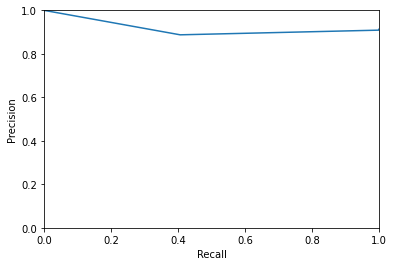

In [ ]:
ArecallList,AprecisionList  = zip(*sorted(zip(recallList,precisionList)))
plt.plot(ArecallList,AprecisionList)
plt.ylim([0,1])
plt.xlim([0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [ ]:
# from sklearn.model_selection import GridSearchCV
# DOESNT WORK :(

#Step 4b
Used GridSearch for hyperparameter optimization to find good hyper parameters

In [ ]:
def GridSearch(model, train_images, train_labels, loss, hyperParam):
    learning_rate=hyperParam['learning']
    momentum=hyperParam['momentum']
    currBestAcc = 0
    bestLR = 0
    bestMom = 0
    for lr in learning_rate:
        for m in momentum:
            print(f"STARTING LR:{lr} MOMENTUM:{m}")
            model = Sequential([
                Linear(784, 30),  # Hidden layer 1: size 30
                # dropout1,
                Relu(),
                Linear(30, 10),   # Hidden layer 2: size 10
                # dropout2,
                Relu(),
                Linear(10, 2),    # Output layer: size 10
                Sigmoid()
            ])

            optimizer = Momentum(learning_rate=lr, momentum=m)
            loss = SoftmaxCrossEntropy()
            acc, avg_loss = loop(model, train_images, train_labels, loss, optimizer)
            if acc>currBestAcc:
                bestLR = lr
                bestMom = m
                currBestAcc = acc
            print(f"final acc{acc} loss{avg_loss}")
            print(f"BEST LR: {bestLR} Momentum: {bestMom}")
    print(f"the best learning rate momentum combo was LR: {bestLR} Momentum: {bestMom}")
    return bestLR, bestMom

In [ ]:
params = {"learning":[0.01,0.1], "momentum":[0.4,0.99]}
bestLR, bestMom = GridSearch(model, train_images, train_labels, loss, params)

STARTING LR:0.01 MOMENTUM:0.4


mnist loss: 0.694 acc: 0.429:   0%|          | 6/5000 [00:00<02:55, 28.39it/s]

failed to calc precision

Pres = 1 Recall: 0.0


mnist loss: 0.542 acc: 0.873:  20%|██        | 1005/5000 [00:40<02:33, 26.00it/s]


Pres = 0.8957688338493293 Recall: 0.9720044792833147


mnist loss: 0.471 acc: 0.893:  40%|████      | 2005/5000 [01:20<01:53, 26.41it/s]


Pres = 0.913 Recall: 1.0


mnist loss: 0.443 acc: 0.900:  60%|██████    | 3006/5000 [01:58<01:13, 27.05it/s]


Pres = 0.912 Recall: 1.0


mnist loss: 0.428 acc: 0.902:  80%|████████  | 4004/5000 [02:41<00:38, 25.77it/s]


Pres = 0.909 Recall: 1.0


mnist loss: 0.417 acc: 0.905: 100%|██████████| 5000/5000 [03:25<00:00, 24.36it/s]


final acc0.9046 loss0.4168641964239148
BEST LR: 0.01 Momentum: 0.4
STARTING LR:0.01 MOMENTUM:0.99


mnist loss: 0.693 acc: 0.500:   0%|          | 6/5000 [00:00<02:56, 28.29it/s]

failed to calc precision

Pres = 1 Recall: 0.0


mnist loss: 0.611 acc: 0.837:  20%|██        | 1004/5000 [00:38<02:25, 27.41it/s]


Pres = 0.8968512486427795 Recall: 0.9249720044792833


mnist loss: 0.517 acc: 0.875:  40%|████      | 2004/5000 [01:15<02:36, 19.14it/s]


Pres = 0.913 Recall: 1.0


mnist loss: 0.479 acc: 0.888:  60%|██████    | 3006/5000 [01:53<01:12, 27.36it/s]


Pres = 0.912 Recall: 1.0


mnist loss: 0.460 acc: 0.893:  80%|████████  | 4005/5000 [02:31<00:37, 26.66it/s]


Pres = 0.909 Recall: 1.0


mnist loss: 0.446 acc: 0.897: 100%|██████████| 5000/5000 [03:08<00:00, 26.48it/s]


final acc0.8974 loss0.44590439439645313
BEST LR: 0.01 Momentum: 0.4
STARTING LR:0.1 MOMENTUM:0.4


mnist loss: 0.694 acc: 0.500:   0%|          | 6/5000 [00:00<03:05, 26.87it/s]


Pres = 1.0 Recall: 1.0


mnist loss: 0.419 acc: 0.902:  20%|██        | 1006/5000 [00:37<02:28, 26.82it/s]


Pres = 0.9019211324570273 Recall: 0.9988801791713325


mnist loss: 0.392 acc: 0.924:  40%|████      | 2005/5000 [01:15<01:48, 27.54it/s]


Pres = 0.9603429796355841 Recall: 0.9813800657174151


mnist loss: 0.382 acc: 0.933:  60%|██████    | 3005/5000 [01:52<01:12, 27.47it/s]


Pres = 0.9655172413793104 Recall: 0.9824561403508771


mnist loss: 0.379 acc: 0.936:  80%|████████  | 4004/5000 [02:29<00:38, 25.68it/s]


Pres = 0.9600862998921251 Recall: 0.9790979097909791


mnist loss: 0.374 acc: 0.940: 100%|██████████| 5000/5000 [03:07<00:00, 26.62it/s]


final acc0.9402 loss0.3737948447962818
BEST LR: 0.1 Momentum: 0.4
STARTING LR:0.1 MOMENTUM:0.99


mnist loss: 0.700 acc: 0.500:   0%|          | 6/5000 [00:00<02:58, 27.91it/s]


Pres = 1.0 Recall: 1.0


mnist loss: 0.448 acc: 0.893:  20%|██        | 1005/5000 [00:37<02:23, 27.88it/s]


Pres = 0.893 Recall: 1.0


mnist loss: 0.420 acc: 0.903:  40%|████      | 2005/5000 [01:14<01:55, 25.93it/s]


Pres = 0.913 Recall: 1.0


mnist loss: 0.404 acc: 0.912:  60%|██████    | 3005/5000 [01:51<01:14, 26.81it/s]


Pres = 0.936656282450675 Recall: 0.9890350877192983


mnist loss: 0.395 acc: 0.921:  80%|████████  | 4005/5000 [02:31<00:39, 25.18it/s]


Pres = 0.9662309368191722 Recall: 0.9757975797579758


mnist loss: 0.389 acc: 0.926: 100%|██████████| 5000/5000 [03:09<00:00, 26.36it/s]

final acc0.9258 loss0.389380984655663
BEST LR: 0.1 Momentum: 0.4
the best learning rate momentum combo was LR: 0.1 Momentum: 0.4


#Step 4b
Training model with full dataset and best hyperparams

In [ ]:
train_images, train_labels, test_images, test_labels = dataget.image.fashion_mnist().get()
train_images = train_images.tolist()
train_labels = train_labels.tolist()
avg = tensor_sum(train_images) / 60000 / 28 / 28
# split = 5000   REMOVING THIS TO USE ALL DATA
# Recenter, rescale, and flatten
train_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                for image in train_images]#[:split]]
test_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                for image in test_images]#[:1000]]
                
train_labels = [one_hot_encode(label) for label in train_labels]
test_labels = [one_hot_encode(label) for label in test_labels]  

In [ ]:
model = Sequential([
    Linear(784, 30),  # Hidden layer 1: size 30
    # dropout1,
    Relu(),
    Linear(30, 10),   # Hidden layer 2: size 10
    # dropout2,
    Relu(),
    Linear(10, 2),    # Output layer: size 10
    Sigmoid()
])
optimizer = Momentum(learning_rate=bestLR, momentum=bestMom)
loss = SoftmaxCrossEntropy()

# Enable dropout and train (takes > 20 minutes on my laptop!)
# dropout1.train = dropout2.train = True
loop(model, train_images, train_labels, loss, optimizer)

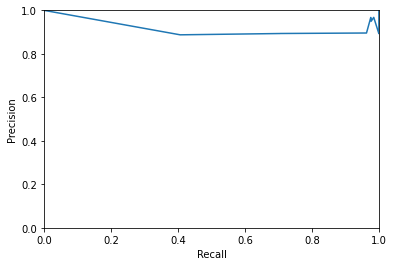

In [ ]:
ArecallList,AprecisionList  = zip(*sorted(zip(recallList,precisionList)))
plt.plot(ArecallList,AprecisionList)
plt.ylim([0,1])
plt.xlim([0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()